In [1]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
# from langchain_experimental.utilities import PythonREPL
from typing import Literal
from typing_extensions import TypedDict
from openai import AzureOpenAI
# from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command



In [68]:
members = ["researcher","coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
# llm = AzureOpenAI(
#         azure_endpoint="https://oai-tss-sweden.openai.azure.com/",
#         api_version="2024-02-01",
#         api_key="f0c2aee69c914b35aa55732deb3532be"
#         )
class State(MessagesState):
    next: str

def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [69]:
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
import os

tavily_tool = TavilySearchResults(max_results=1,api_key=os.environ.get("TAVILY_API_KEY"),include_domains = ['www.healthyschoolrecipes.com'])
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",
    api_version="2024-08-01-preview",  
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    azure_endpoint="https://oai-tss-sweden.openai.azure.com/",
    api_key="f0c2aee69c914b35aa55732deb3532be"
)
research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a expert in getting the ingredients for the respective recipe. DO NOT do any math."
)


In [70]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

code_agent = create_react_agent(llm,tools=[])

def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [71]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)

# builder.add_edge("supervisor","researcher")
builder.add_node("coder", code_node)
graph = builder.compile()

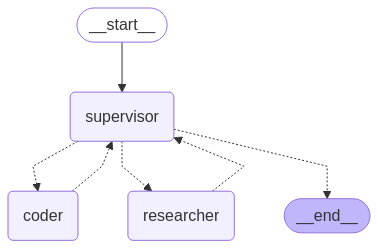

In [72]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
for s in graph.stream({"messages": [("user", "what are the ingredients recipe for Stromboli")]}, subgraphs=True):
    # Extract just the meaningful parts from each state
    if "agent" in s and "messages" in s["agent"]:
        print(f"Agent message: {s['agent']['messages'][-1].content}")
    elif "tools" in s:
        print(f"Tool result: {s['tools']['messages'][-1].content}")
    elif "researcher" in s and "messages" in s["researcher"]:
        print(f"Researcher: {s['researcher']['messages'][-1].content}")
    else:
        print("State transition:", s)
    print("----")

State transition: ((), {'supervisor': {'next': 'researcher'}})
----
State transition: (('researcher:b2e61480-7930-d4c5-4774-e6d27aa9ffe1',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RsOgcSsXjggGol95PWAzBfl3', 'function': {'arguments': '{"query":"Stromboli recipe ingredients"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 107, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ded0d14823', 'id': 'chatcmpl-BQAZMTABa23eOmanBuxnc3VqI04Wq', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False,

In [53]:
final_response = None
for s in graph.stream({"messages": [("user", "what are the ingredients recipe for Healthy Pasta with Spicy Crab")]}, subgraphs=True):
    if "researcher" in s[1] and "messages" in s[1]["researcher"]:
        final_response = s[1]["researcher"]["messages"][-1].content
    elif "coder" in s[1] and "messages" in s[1]["coder"]:
        final_response = s[1]["coder"]["messages"][-1].content
    # else:
    #     print(s)


print(final_response)


I couldn't find specific information on the ingredients for a "Healthy Pasta with Spicy Crab" recipe. However, a typical recipe might include the following ingredients:

- Whole wheat pasta or gluten-free pasta
- Fresh crab meat (or canned crab)
- Olive oil
- Garlic (minced)
- Red pepper flakes (for spice)
- Cherry tomatoes (halved)
- Spinach or arugula
- Lemon juice
- Fresh herbs (like parsley or basil)
- Salt and pepper to taste

You may want to check a reliable cooking website or cookbook for a detailed recipe.


In [30]:
st=((), {'coder': {'messages': [HumanMessage(content='The term "4 square" can refer to a couple of different concepts depending on the context:\n\n1. **Mathematics**: If you\'re referring to the mathematical operation, "4 squared" means \\(4^2\\), which equals \\(16\\).\n\n2. **Game**: "Four square" is also a playground game played with a ball and four players, where players bounce a ball between squares drawn on the ground.\n\nIf you meant something else by "4 square," please provide more context!', additional_kwargs={}, response_metadata={}, name='coder')]}})


In [35]:
if "messages" in st[1]['coder']:
      print("True")

True


In [32]:
st

((),
 {'coder': {'messages': [HumanMessage(content='The term "4 square" can refer to a couple of different concepts depending on the context:\n\n1. **Mathematics**: If you\'re referring to the mathematical operation, "4 squared" means \\(4^2\\), which equals \\(16\\).\n\n2. **Game**: "Four square" is also a playground game played with a ball and four players, where players bounce a ball between squares drawn on the ground.\n\nIf you meant something else by "4 square," please provide more context!', additional_kwargs={}, response_metadata={}, name='coder')]}})